# Intensity investigation using UMAP and manual clustering

In [1]:
import napari
from napari.utils import nbscreenshot
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
import os
from skimage.io import imread
import numpy as np
from skimage import measure
from napari_clusters_plotter._dimensionality_reduction import DimensionalityReductionWidget
from napari_clusters_plotter._dock_widget import PlotterWidget
from napari_skimage_regionprops import add_table

## Difference between the nuclei and the membrane channel

The dataset of the marine annelid Platynereis dumerilii from  [Ozpolat, B. et al](https://doi.org/10.5281/zenodo.1063531) licensed by [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/legalcode) is a multichannel image as you will see in a minute.

In order to show the difference between the channels, we need to merge the individual rescaled (256x256x103) timepoints by opening them as a stack in napari.

The labels were generated with [StarDist](https://github.com/stardist/stardist).

In [2]:
nuclei_loc = "C:/Users/maral/Documents/WHK Bio-image Analysis Group/1. Nuclei und Zellen segmentieren, tracken, klassifizieren/Image 6 single timepoints gaussian (256x256x103)/"
membrane_loc = "C:/Users/maral/Documents/WHK Bio-image Analysis Group/1. Nuclei und Zellen segmentieren, tracken, klassifizieren/Image 6 single timepoints gaussian channel 0(256x256x103)/"
label_loc = "C:/Users/maral/Documents/WHK Bio-image Analysis Group/1. Nuclei und Zellen segmentieren, tracken, klassifizieren/Image 6 single timepoints labels/"

In [3]:
#append directory and sort
def get_sorted_image_list(directory):
    files = [join(directory, f) for f in listdir(directory) if isfile(join(directory, f)) and f.endswith('tif')]
    return sorted(files)

In [4]:
all_nuclei_locs = get_sorted_image_list(nuclei_loc)
all_membrane_locs = get_sorted_image_list(membrane_loc)
all_label_locs = get_sorted_image_list(label_loc)

In [5]:
#open napari 
viewer = napari.Viewer()
nuclei_layer = viewer.open(all_nuclei_locs, stack=True, plugin="builtins", name = "nuclei")
membrane_layer = viewer.open(all_membrane_locs, stack=True, plugin="builtins", name = "membranes")

C:\Users\maral\mambaforge\envs\ncp_paper\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(
C:\Users\maral\mambaforge\envs\ncp_paper\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Now we set the visualization to 3D:

In [6]:
viewer.dims.ndisplay=3

As you can see, we loaded a nuclei and a membrane channel into napari. But the membrane channel does not only contain membranes but also some of the objects present in the nuclei channel. We now load a segmentation result of the nuclei channel and want to find out if we can differentiate two groups of nuclei:
- __1st group__: objects which are present both in the nuclei and membrane channel
- __2nd group__: objects which are only present in the nuclei channel

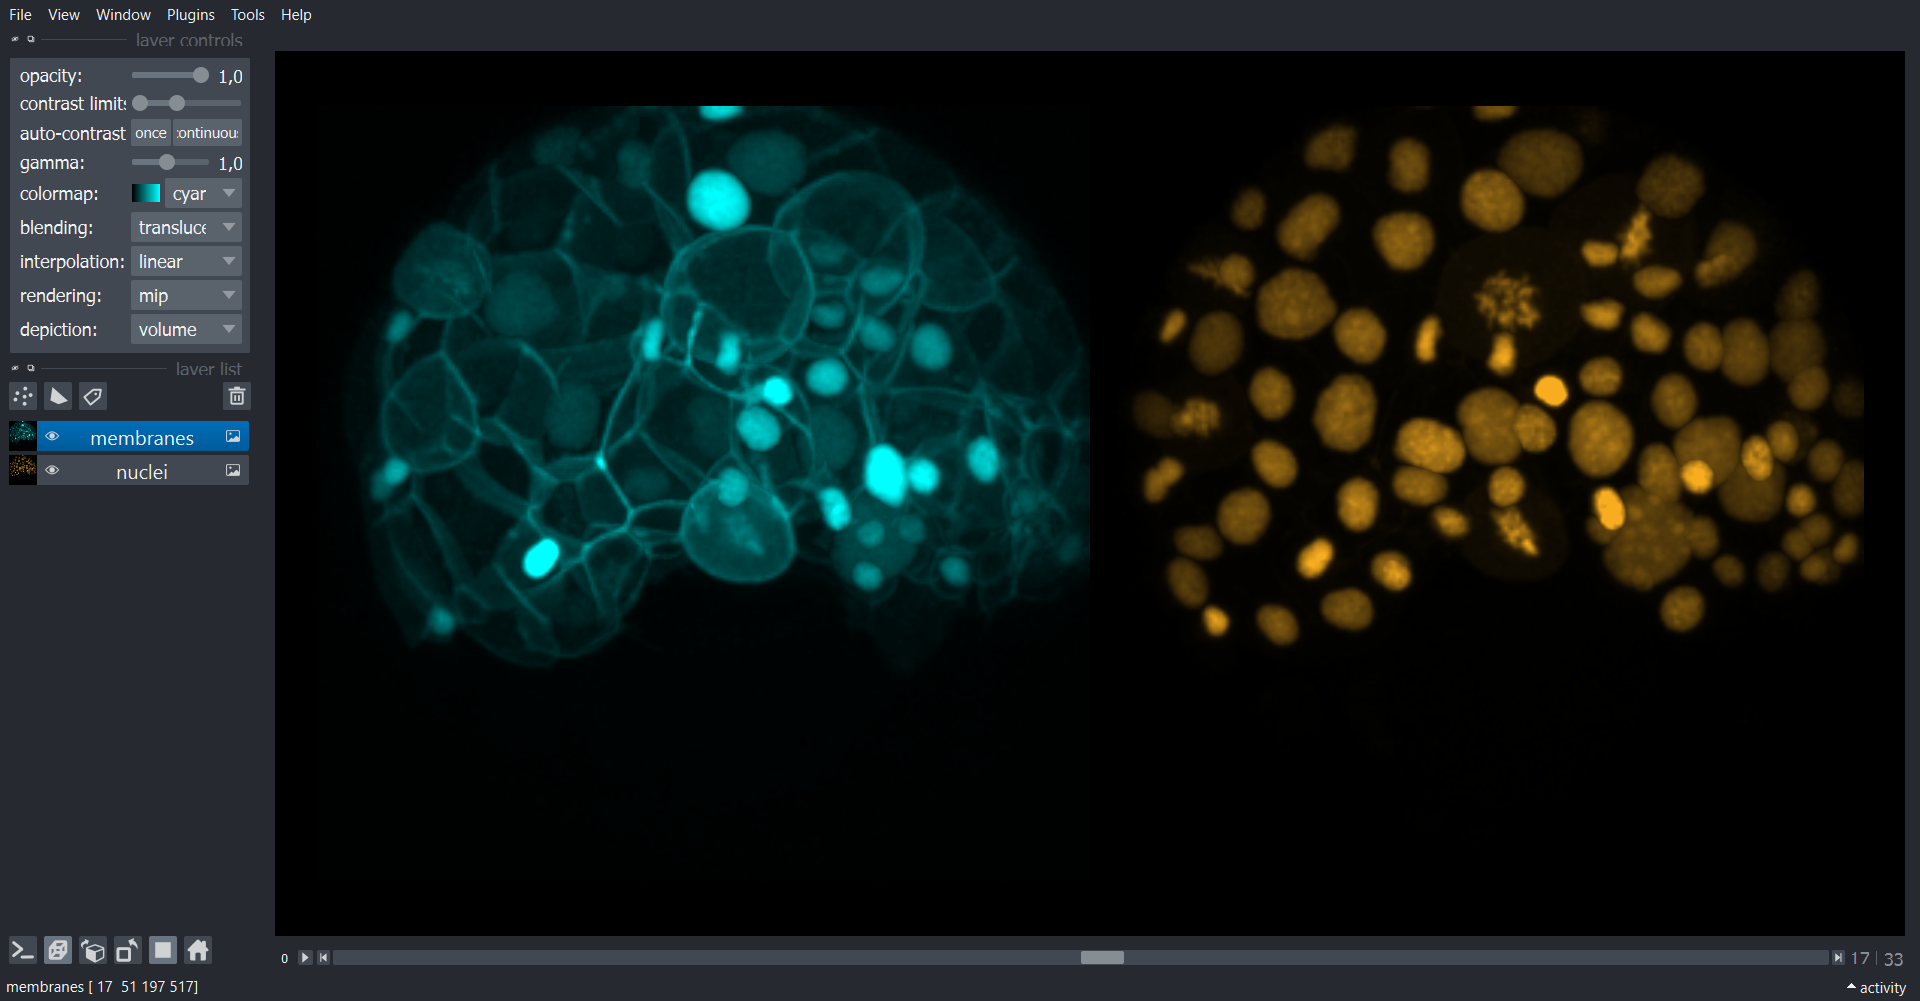

In [7]:
nbscreenshot(viewer)

## Feature extraction

### ... from membrane channel

> **_Note:_** For this investigation, we __only use intensity-based parameters__. The reason is that we want to distinguish between nuclei labels in the nuclei and the membrane channel. Hereby, the intensity-based parameters are measured on the original image (in our case the membrane channel) and the others (like size and shape) on the label image. That makes it more a technical interesting investigation than a biological one.

In [18]:
membrane_list = []
for labels, membrane, i in zip(all_label_locs, all_membrane_locs, range(len(all_membrane_locs))):
    labels = imread(labels)
    membrane = imread(membrane)
    table = pd.DataFrame(measure.regionprops_table(labels, membrane, properties=['label', 
                                                                                'intensity_mean',
                                                                                'intensity_max',
                                                                                'intensity_min'
    ]))
    table['frame'] = i
    membrane_list.append(table)

The `frame` column corresponds to the timepoint.

In [19]:
membrane_table = pd.concat(membrane_list)
membrane_table

label  intensity_mean  intensity_max  intensity_min  frame
0        1        0.370741       0.707742       0.030328      0
1        2        0.067627       0.118126       0.010130      0
2        3        0.045129       0.084016       0.013233      0
3        4        0.034841       0.059639       0.011443      0
4        5        0.047609       0.075320       0.009169      0
..     ...             ...            ...            ...    ...
192    193        0.022349       0.037803       0.011589     33
193    194        0.206956       0.268527       0.106839     33
194    195        0.056816       0.080725       0.041119     33
195    196        0.088481       0.159896       0.053539     33
196    197        0.070520       0.150340       0.048425     33

[3048 rows x 5 columns]

In [9]:
viewer.open(all_label_locs, stack=True, plugin="builtins", layer_type = "labels", features = membrane_table, name = "nuclei labels")
label_layer = viewer.layers["nuclei labels"]
add_table(label_layer, viewer)

C:\Users\maral\mambaforge\envs\ncp_paper\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Napari status bar display of label properties disabled because https://github.com/napari/napari/issues/5417 and https://github.com/napari/napari/issues/4342


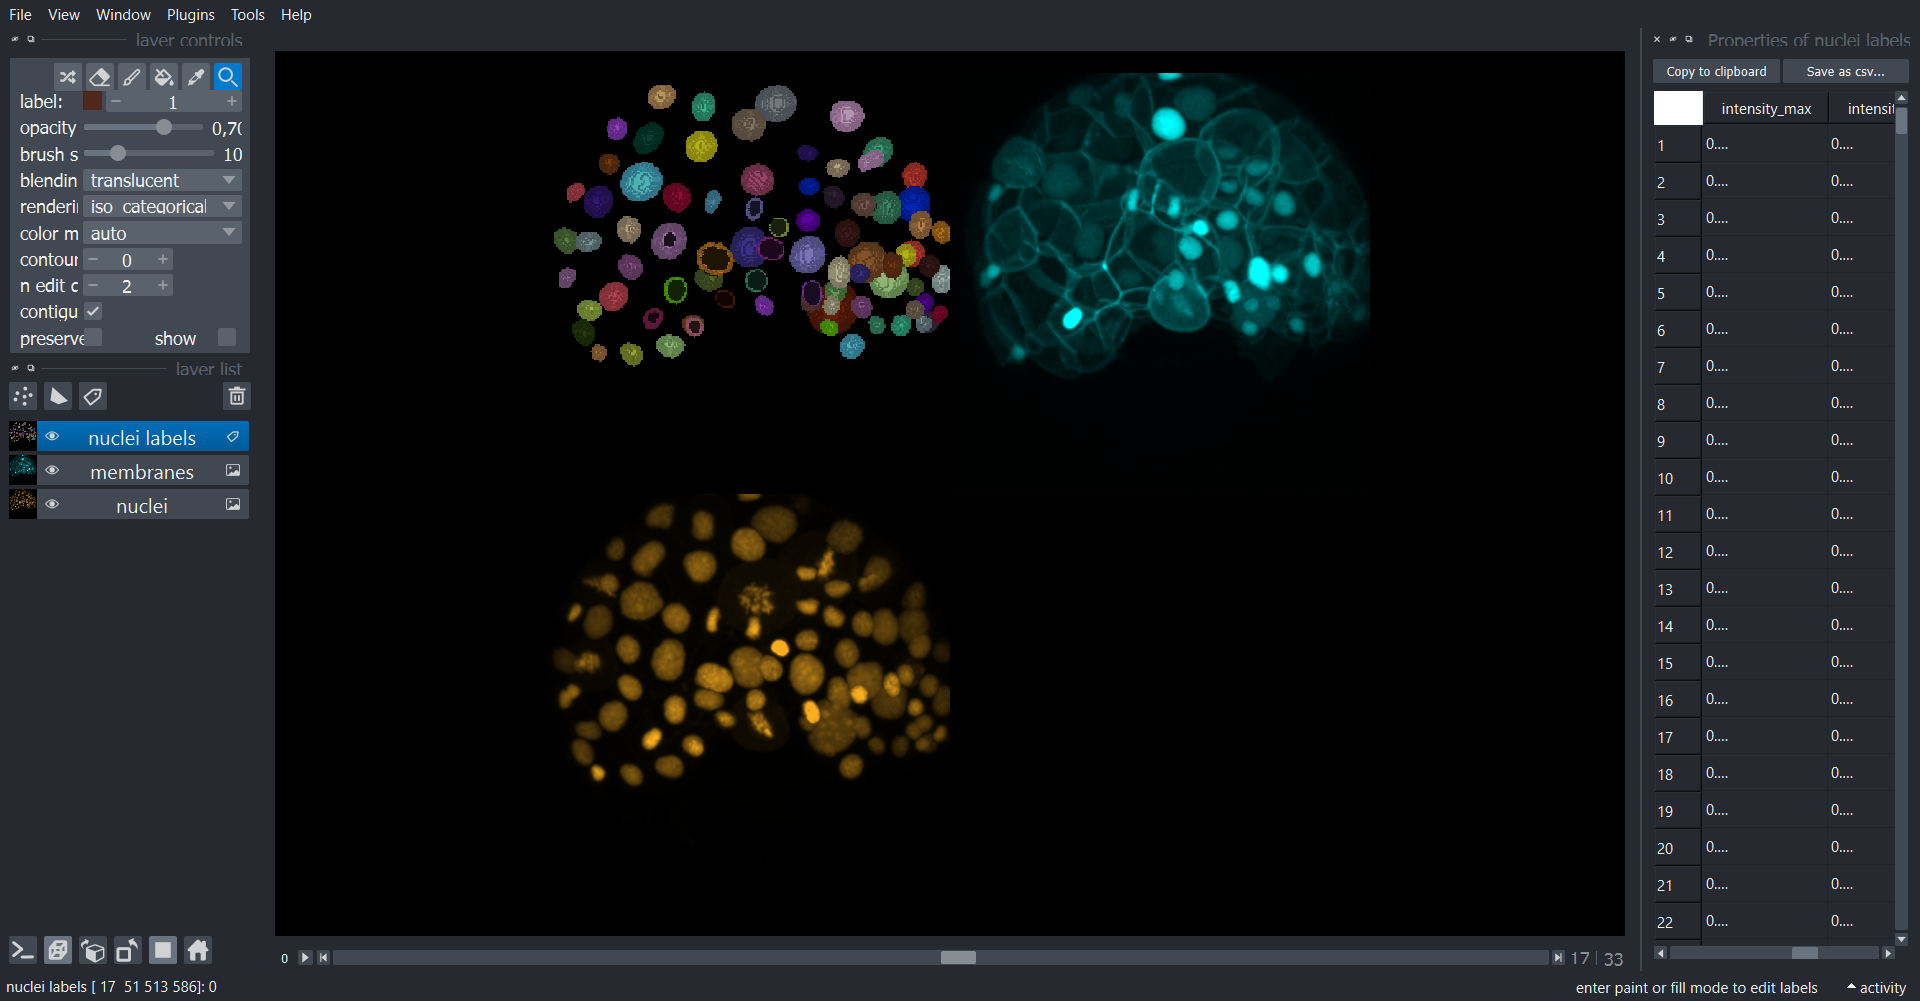

In [13]:
nbscreenshot(viewer)

## Dimensionality reduction

In [10]:
dimensionality_reduction_widget = DimensionalityReductionWidget(viewer)
dimensionality_reduction_dock_widget = viewer.window.add_dock_widget(dimensionality_reduction_widget)

Selected labels layer: nuclei labels
Selected measurements: ['intensity_mean', 'intensity_max', 'intensity_min']


C:\Users\maral\mambaforge\envs\ncp_paper\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\maral\mambaforge\envs\ncp_paper\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\maral\mambaforge\envs\ncp_paper\lib\site-packages\umap\distances.py:108

Napari status bar display of label properties disabled because https://github.com/napari/napari/issues/5417 and https://github.com/napari/napari/issues/4342
Dimensionality reduction finished


Next, we select `UMAP` as a dimensionality reduction algorithm and run the dimensionality reduction. We only have 3 parameters that we feed in, so only one dimension is reduced in this example.

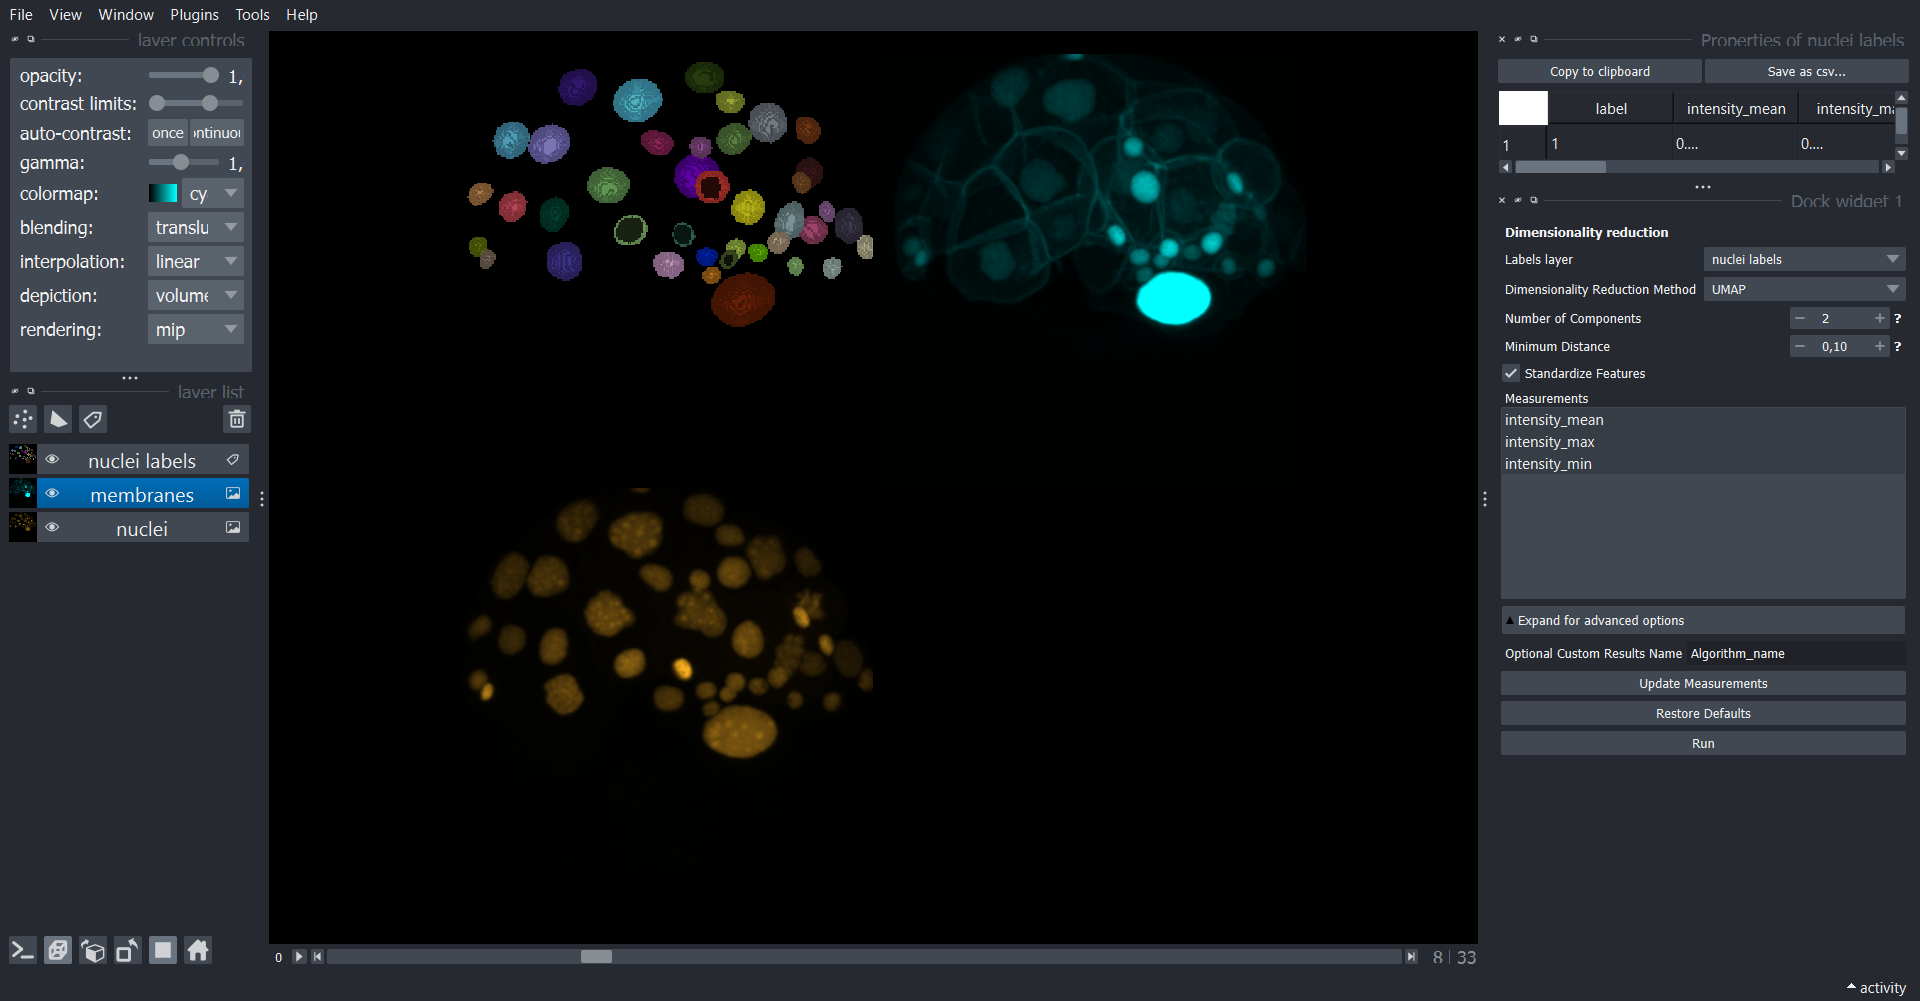

In [13]:
nbscreenshot(viewer)

In [11]:
dimensionality_reduction_widget.hide()

## Plotting

Now, we plot our `UMAP_0` against `UMAP_1`:

In [12]:
plotter_widget = PlotterWidget(viewer)
plotter_dock_widget = viewer.window.add_dock_widget(plotter_widget)

In [ ]:
plotter_widget.plot_x_axis.setCurrentText("UMAP_0")
plotter_widget.plot_y_axis.setCurrentText("UMAP_1")

# workaround to click run button programmatically
layout = plotter_widget.layout()
widgetitem = layout.itemAt(layout.count()-2)
run_button = widgetitem.widget().layout().itemAt(0).widget()
run_button.clicked.emit()

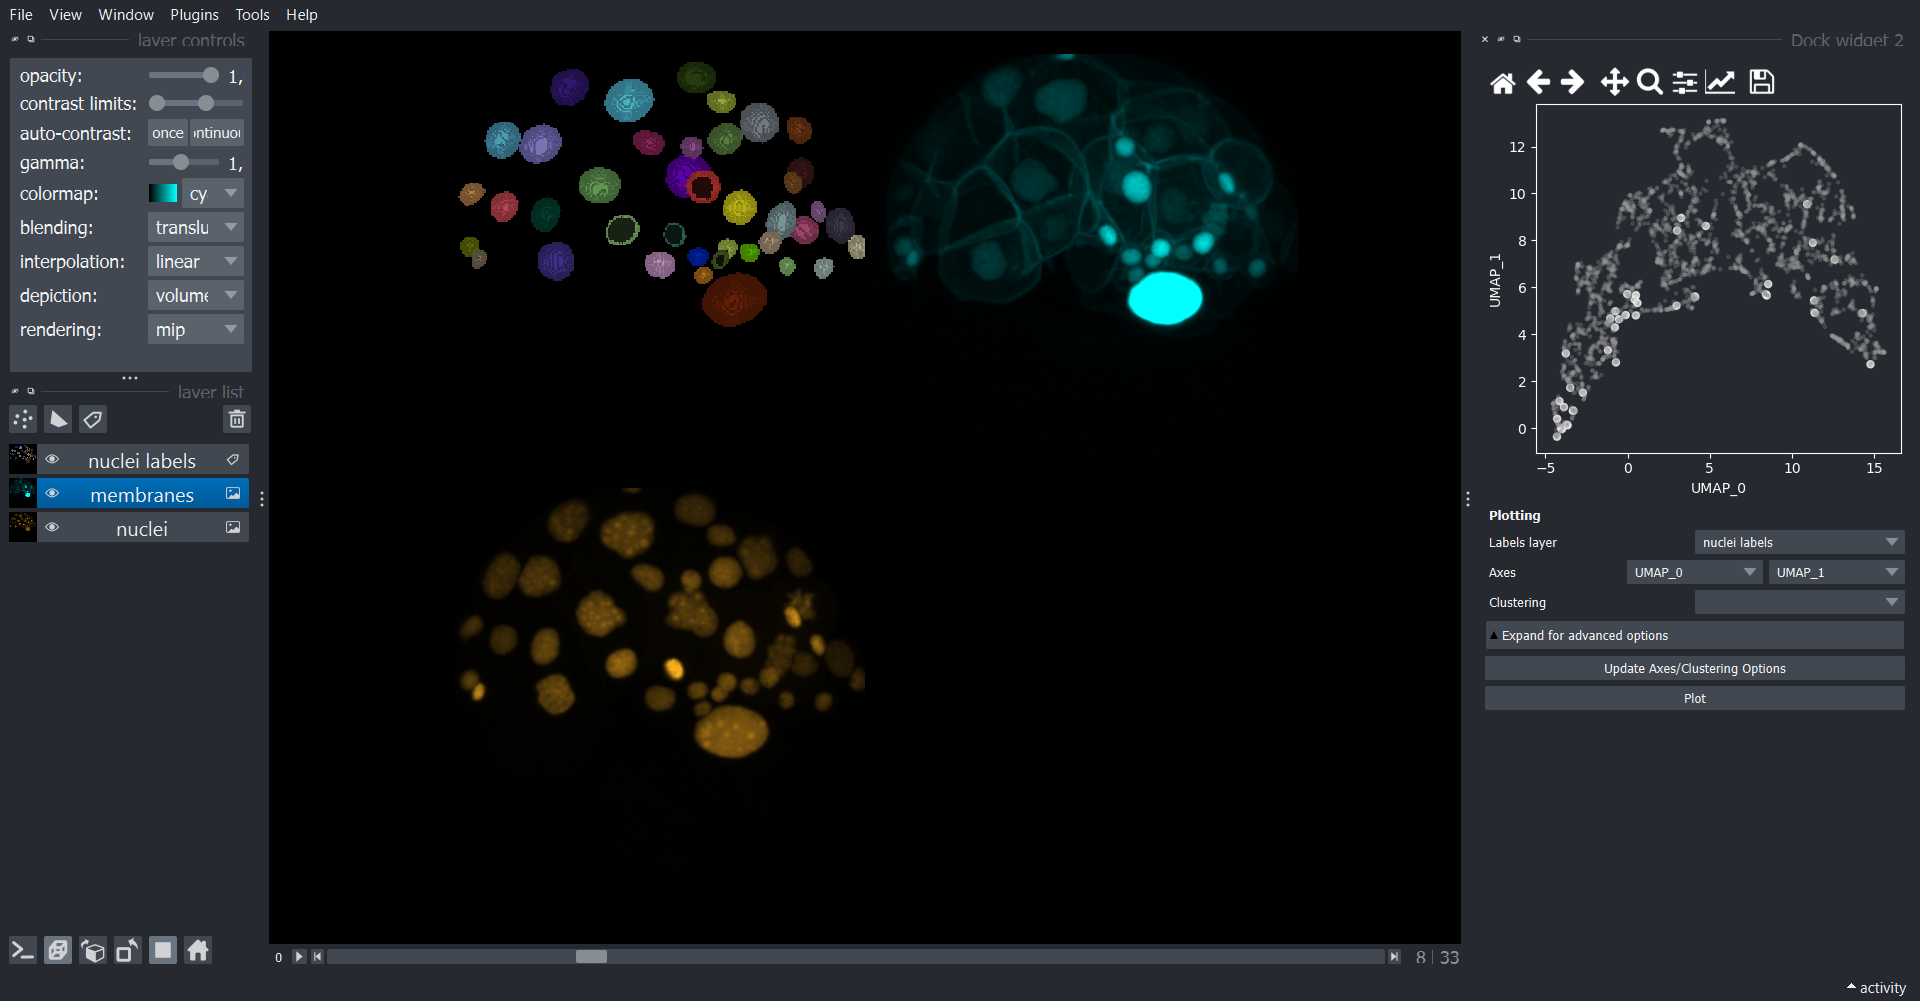

In [13]:
nbscreenshot(viewer)

## Manual clustering

We can select groups of datapoints using manual clustering with the lasso tool:

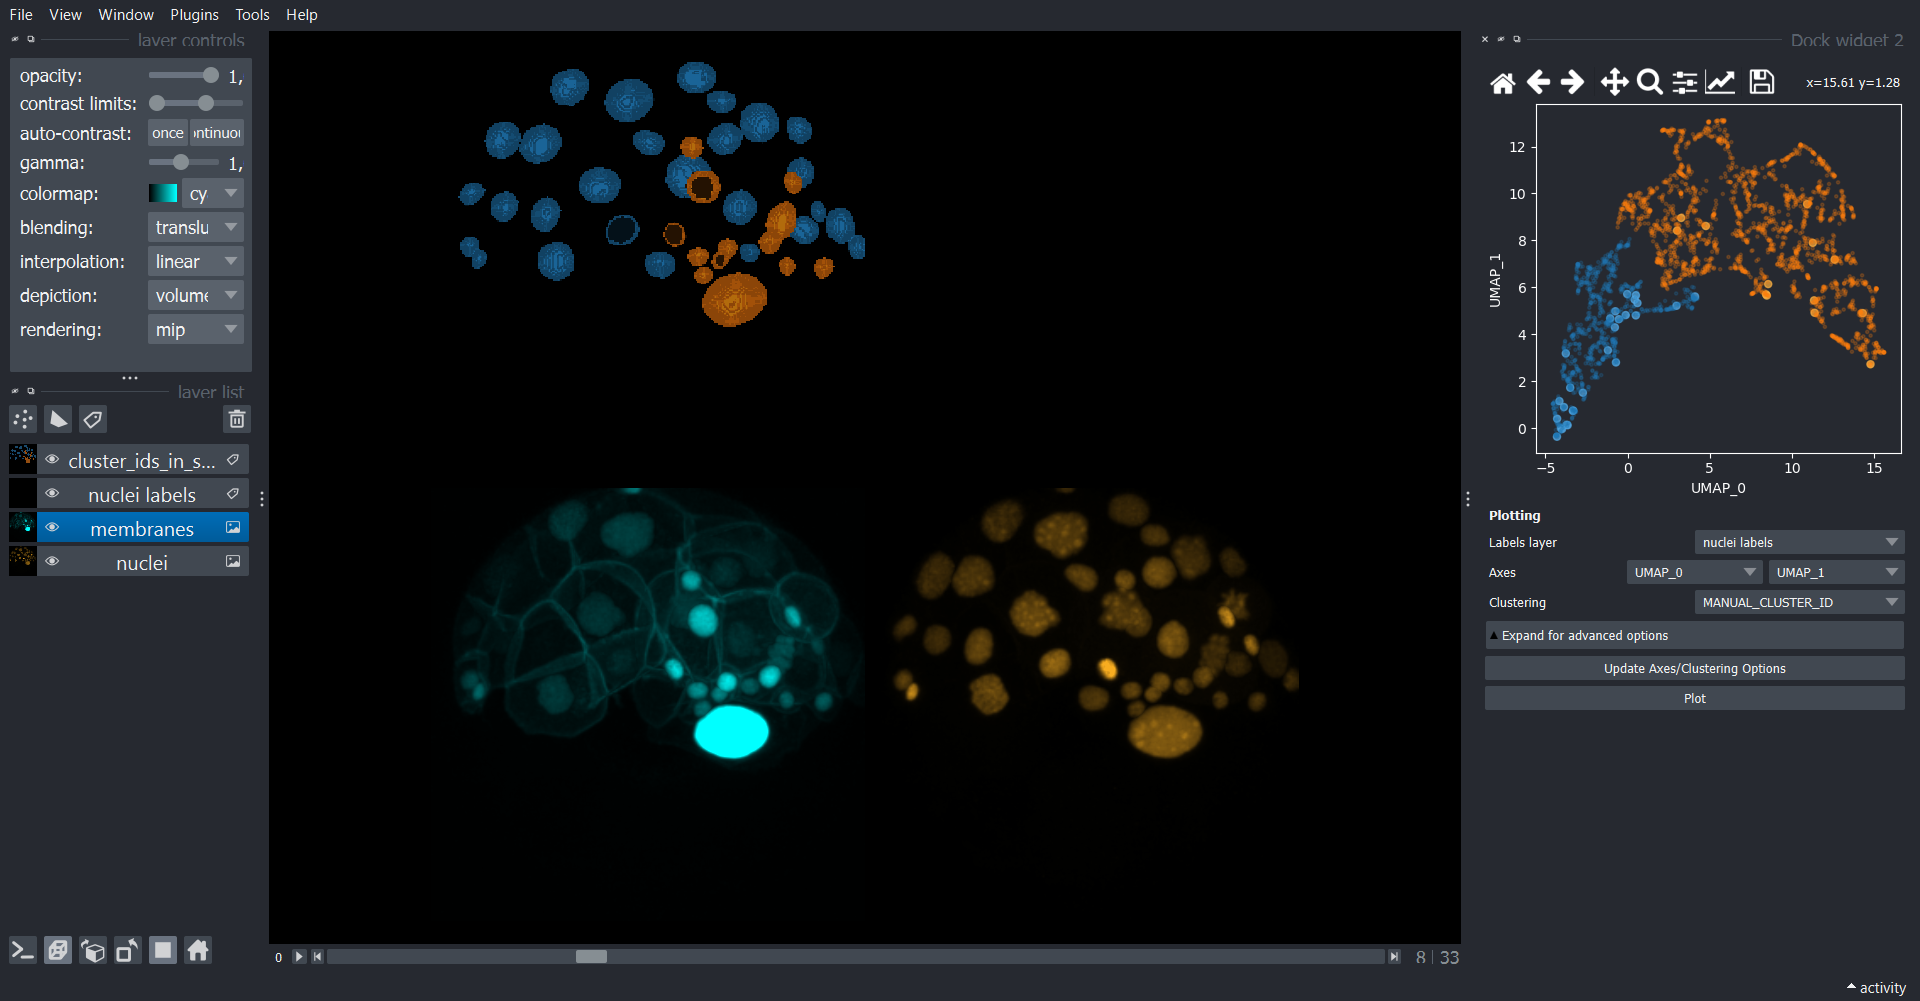

In [14]:
nbscreenshot(viewer)

We could now generate the hypothesis that orange labels correspond to bright objects in the membrane channel. Let's select a second cluster by holding `SHIFT`.

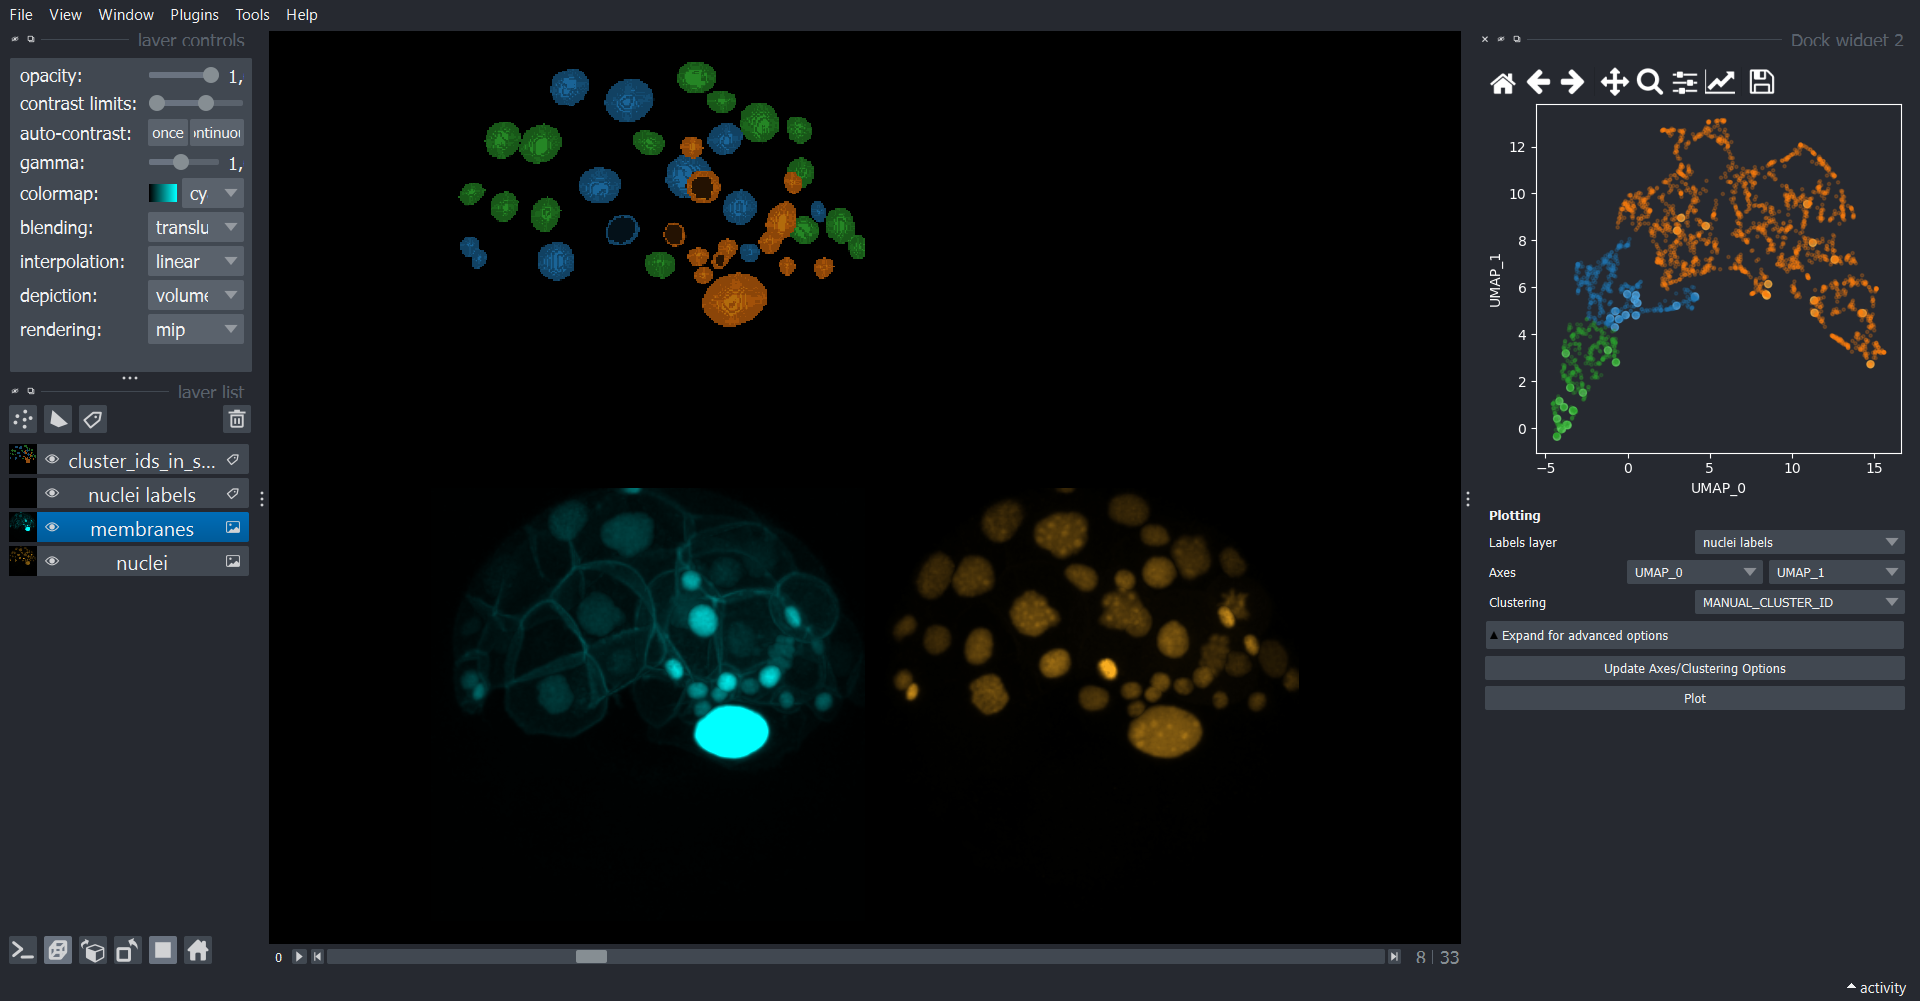

In [17]:
nbscreenshot(viewer)

We could now generate another hypothesis that blue labels correspond to less bright objects in the membrane channel.

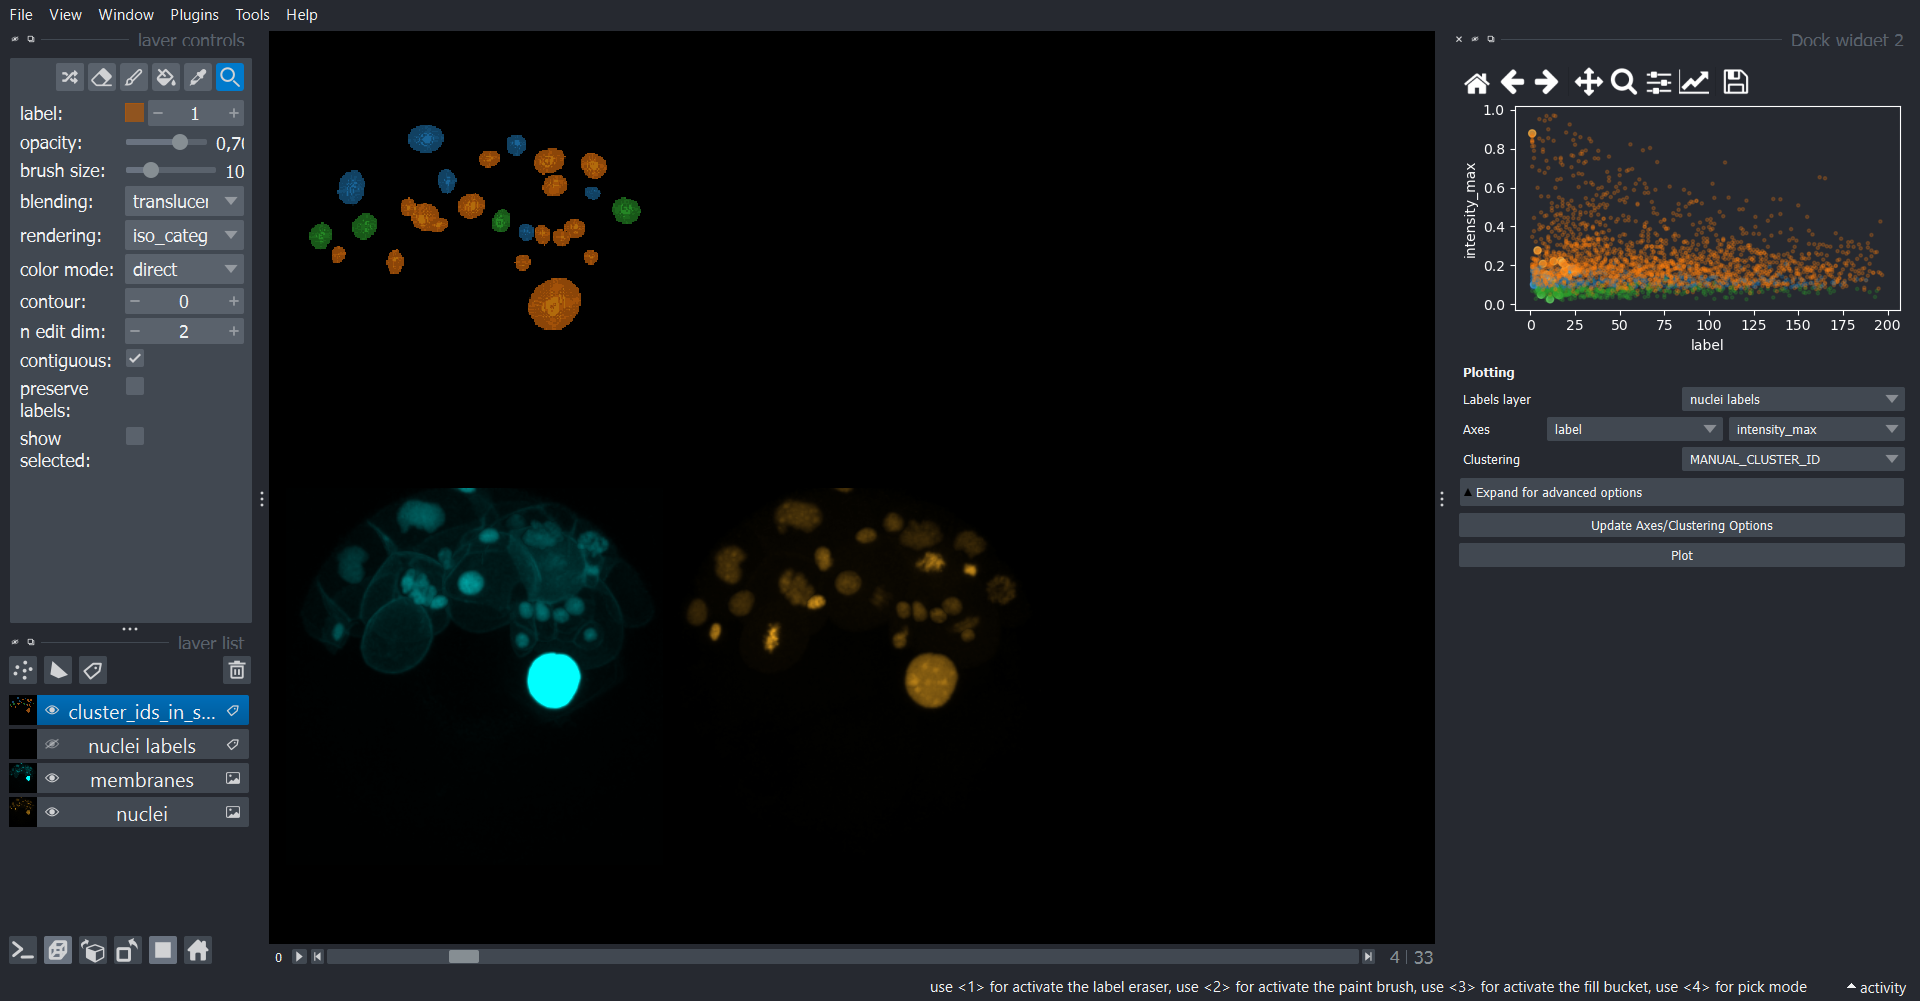

In [31]:
nbscreenshot(viewer)

## Comparing UMAP of intensity values of nuclei between nuclei and membrane channel

In [22]:
nuclei_list = []
for labels, nuclei, i in zip(all_label_locs, all_nuclei_locs, range(len(all_nuclei_locs))):
    labels = imread(labels)
    nuclei = imread(nuclei)
    table = pd.DataFrame(measure.regionprops_table(labels, nuclei, properties=['label', 
                                                                                'intensity_mean',
                                                                                'intensity_max',
                                                                                'intensity_min'
    ]))
    table['frame'] = i
    nuclei_list.append(table)

In [23]:
nuclei_table = pd.concat(nuclei_list)
nuclei_table

label  intensity_mean  intensity_max  intensity_min  frame
0        1        0.136680       0.297344       0.011053      0
1        2        0.102371       0.247868       0.008247      0
2        3        0.107302       0.363302       0.012222      0
3        4        0.073819       0.196801       0.008310      0
4        5        0.084881       0.165792       0.006476      0
..     ...             ...            ...            ...    ...
192    193        0.052266       0.074895       0.017502     33
193    194        0.351559       0.744285       0.067796     33
194    195        0.199831       0.430042       0.053522     33
195    196        0.248964       0.463827       0.059397     33
196    197        0.206445       0.408523       0.042788     33

[3048 rows x 5 columns]

In [25]:
viewer.open(all_label_locs, stack=True, plugin="builtins", layer_type = "labels", features = nuclei_table, name = "nuclei labels")
label_layer = viewer.layers["nuclei labels"]
add_table(label_layer, viewer)

C:\Users\maral\mambaforge\envs\ncp_paper\lib\site-packages\napari\components\viewer_model.py:977: UserWarning: The "builtins" plugin name is deprecated and will not work in a future version. Please use "napari" instead.
  warnings.warn(


Napari status bar display of label properties disabled because https://github.com/napari/napari/issues/5417 and https://github.com/napari/napari/issues/4342


In [26]:
dimensionality_reduction_widget = DimensionalityReductionWidget(viewer)
dimensionality_reduction_dock_widget = viewer.window.add_dock_widget(dimensionality_reduction_widget)

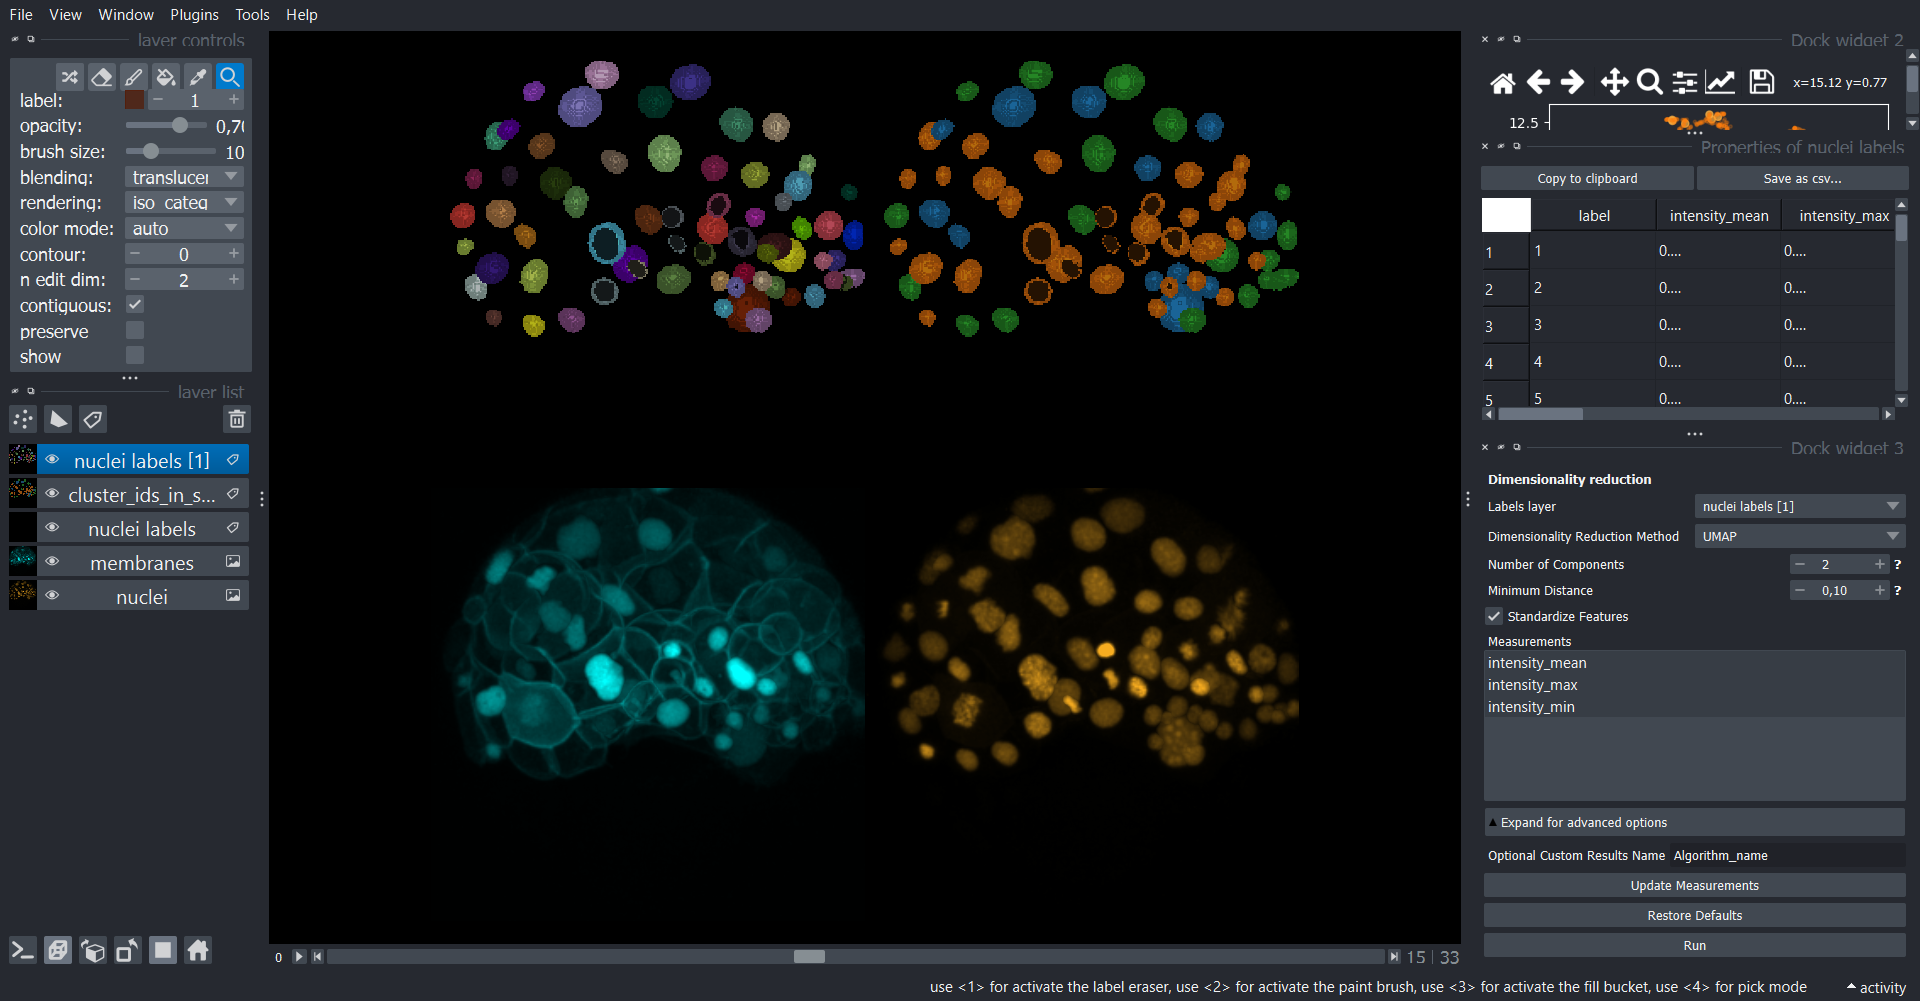

In [27]:
nbscreenshot(viewer)

In [28]:
plotter_widget = PlotterWidget(viewer)
plotter_dock_widget = viewer.window.add_dock_widget(plotter_widget)

Selected labels layer: nuclei labels [1]
Selected measurements: ['intensity_mean', 'intensity_max', 'intensity_min']
Napari status bar display of label properties disabled because https://github.com/napari/napari/issues/5417 and https://github.com/napari/napari/issues/4342
Dimensionality reduction finished


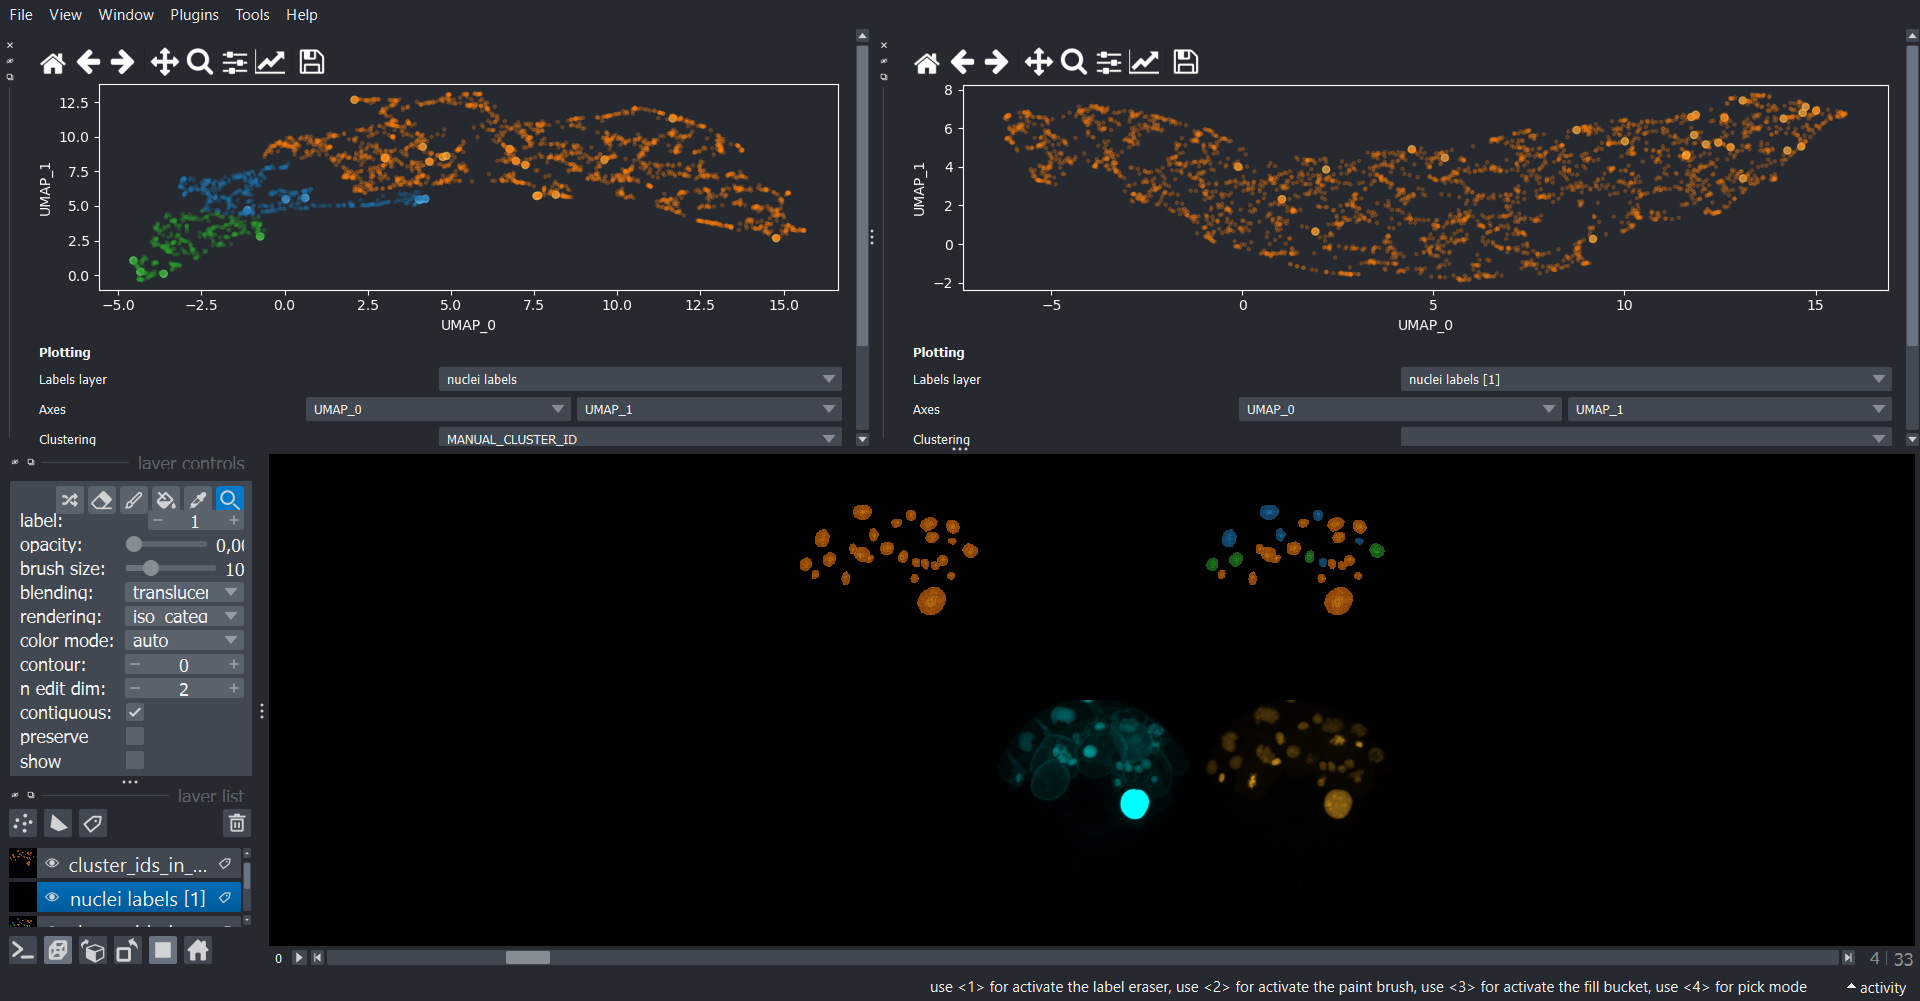

In [30]:
nbscreenshot(viewer)

We can see that the UMAP of the intensity values of the membrane channel (left) differs from the UMAP of the nuclei channel (right). 

Hereby, we needs to keep in mind that the algorithm behind UMAP is partially non-deterministic. This means that if we recompute a UMAP from the same measurements the result can differ. 